# FINM RL Trading - Main Analysis Notebook

This notebook provides comprehensive analysis of all experimental results:
- Core baselines comparison (PPO vs BuyAndHold vs MACrossover)
- Hyperparameter sensitivity analysis
- State/Environment ablation studies
- Regime-based performance analysis
- Reward shaping analysis
- Robustness testing results
- Summary dashboard


In [1]:
# Setup: Paths and Imports
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List

# Set up paths
CURRENT_DIR = Path().resolve()
PROJECT_ROOT = CURRENT_DIR.parent
RESULTS_DIR = PROJECT_ROOT / "results"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")
print(f"RESULTS_DIR = {RESULTS_DIR}")
print(f"Results available: {list(RESULTS_DIR.iterdir()) if RESULTS_DIR.exists() else 'Not found'}")


PROJECT_ROOT = /Users/nickdonato/finm-rl-project
RESULTS_DIR = /Users/nickdonato/finm-rl-project/results
Results available: [PosixPath('/Users/nickdonato/finm-rl-project/results/reward_shaping'), PosixPath('/Users/nickdonato/finm-rl-project/results/ppo_seed_pretrain_compare'), PosixPath('/Users/nickdonato/finm-rl-project/results/states_envs'), PosixPath('/Users/nickdonato/finm-rl-project/results/regimes'), PosixPath('/Users/nickdonato/finm-rl-project/results/pretrain_ma_bc'), PosixPath('/Users/nickdonato/finm-rl-project/results/ppo_hyperparams'), PosixPath('/Users/nickdonato/finm-rl-project/results/core_baselines')]


In [2]:
# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [3]:
# Export utilities
def export_table_csv(df: pd.DataFrame, path: Path) -> None:
    """Export DataFrame to CSV."""
    df.to_csv(path, index=False)
    print(f"Exported table to {path}")

def export_table_latex(df: pd.DataFrame, path: Path, **kwargs) -> None:
    """Export DataFrame to LaTeX format."""
    latex_str = df.to_latex(index=False, **kwargs)
    with open(path, 'w') as f:
        f.write(latex_str)
    print(f"Exported LaTeX table to {path}")

def export_table_html(df: pd.DataFrame, path: Path, **kwargs) -> None:
    """Export DataFrame to HTML format."""
    html_str = df.to_html(index=False, **kwargs)
    with open(path, 'w') as f:
        f.write(html_str)
    print(f"Exported HTML table to {path}")

# Create exports directory
EXPORTS_DIR = PROJECT_ROOT / "notebooks" / "exports"
EXPORTS_DIR.mkdir(exist_ok=True)
print(f"Export directory: {EXPORTS_DIR}")


Export directory: /Users/nickdonato/finm-rl-project/notebooks/exports


## 1. Core Baselines Comparison

Compare PPO performance against simple baselines: BuyAndHold and MACrossover.


In [4]:
# Load core baselines metrics
core_baselines_path = RESULTS_DIR / "core_baselines" / "core_metrics.json"
with open(core_baselines_path, 'r') as f:
    core_metrics = json.load(f)

# Convert to DataFrame for easier analysis
baselines_data = []
for strategy, metrics in core_metrics.items():
    row = {"strategy": strategy}
    row.update(metrics)
    baselines_data.append(row)

baselines_df = pd.DataFrame(baselines_data)
print("Core Baselines Comparison:")
print(baselines_df.to_string(index=False))


Core Baselines Comparison:
   strategy  total_return  annualized_return    sharpe  max_drawdown
        PPO     -0.311087          -0.093557 -0.506943      0.417140
 BuyAndHold      0.879467           0.180960  0.868777      0.244964
MACrossover     -0.199860          -0.057080 -0.273613      0.466907


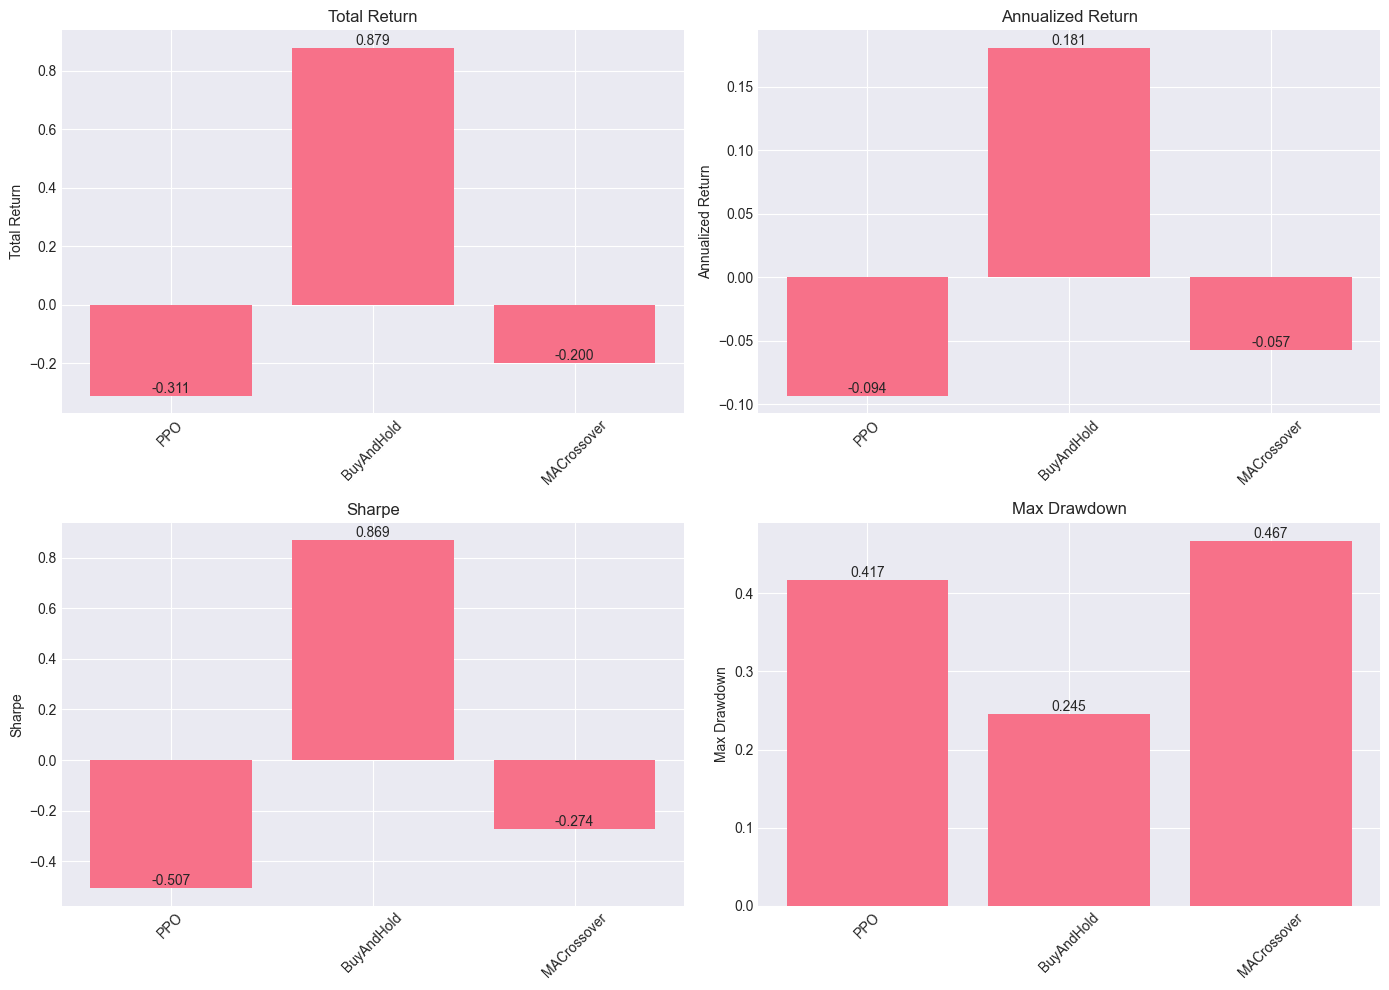

Saved baselines comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.png


In [5]:
# Visualize baselines comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(baselines_df['strategy'], baselines_df[metric])
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(EXPORTS_DIR / "baselines_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved baselines comparison plot to {EXPORTS_DIR / 'baselines_comparison.png'}")


In [6]:
# Export baselines comparison table
export_table_csv(baselines_df, EXPORTS_DIR / "baselines_comparison.csv")
export_table_latex(baselines_df, EXPORTS_DIR / "baselines_comparison.tex", float_format="%.4f")
export_table_html(baselines_df, EXPORTS_DIR / "baselines_comparison.html", classes='table table-striped')

Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.tex
Exported HTML table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.html


## 2. Hyperparameter Sensitivity Analysis

Analyze PPO performance across different hyperparameter configurations:
- Clip epsilon and entropy coefficient grid search
- Gamma and GAE lambda combinations
- Learning rate sensitivity
- Best config optimization (Phase 2)
- Best combo configuration (Phase 3)


In [7]:
# Load hyperparameter results
hyperparams_dir = RESULTS_DIR / "ppo_hyperparams"
hyperparams_summary_path = hyperparams_dir / "summary_test_metrics.csv"

if hyperparams_summary_path.exists():
    hyperparams_df = pd.read_csv(hyperparams_summary_path)
    print("Hyperparameter Summary:")
    print(hyperparams_df.to_string(index=False))
    
    # Load individual run JSONs to extract config details
    run_configs = []
    for json_file in hyperparams_dir.glob("*.json"):
        if json_file.name != "summary_test_metrics.json":
            with open(json_file, 'r') as f:
                run_data = json.load(f)
                if 'config' in run_data:
                    config = run_data['config']
                    name = run_data.get('name', json_file.stem)
                    metrics = run_data.get('test_metrics', {})
                    
                    # Determine phase/category
                    phase = "Phase 1: Initial Sweep"
                    category = "Other"
                    if name.startswith("best_"):
                        if name == "best_combo":
                            phase = "Phase 3: Best Combo"
                            category = "Best Combo"
                        else:
                            phase = "Phase 2: Best Config LR Sweep"
                            category = "Best Config LR"
                    elif name.startswith("clip") and "_ent" in name:
                        category = "Clip/Entropy Grid"
                    elif name.startswith("gamma") and "_lambda" in name:
                        category = "Gamma/GAE Grid"
                    elif name.startswith("lr") and not name.startswith("best_"):
                        category = "Initial LR Sweep"
                    
                    run_configs.append({
                        'name': name,
                        'phase': phase,
                        'category': category,
                        'clip_eps': config.get('clip_eps', None),
                        'entropy_coef': config.get('entropy_coef', None),
                        'gamma': config.get('gamma', None),
                        'gae_lambda': config.get('gae_lambda', None),
                        'lr': config.get('lr', None),
                        **metrics
                    })
    
    if run_configs:
        hyperparams_detailed_df = pd.DataFrame(run_configs)
        print("\nDetailed Hyperparameter Configurations:")
        print(hyperparams_detailed_df[['name', 'phase', 'category', 'clip_eps', 'entropy_coef', 
                                       'gamma', 'gae_lambda', 'lr', 'sharpe', 'total_return']].to_string(index=False))
        
        # Summary by phase
        print("\n=== Summary by Phase ===")
        for phase in hyperparams_detailed_df['phase'].unique():
            phase_data = hyperparams_detailed_df[hyperparams_detailed_df['phase'] == phase]
            best_in_phase = phase_data.loc[phase_data['sharpe'].idxmax()]
            print(f"\n{phase}:")
            print(f"  Total configs: {len(phase_data)}")
            print(f"  Best config: {best_in_phase['name']} (Sharpe: {best_in_phase['sharpe']:.4f})")
        
        # Summary by category
        print("\n=== Summary by Category ===")
        for category in hyperparams_detailed_df['category'].unique():
            cat_data = hyperparams_detailed_df[hyperparams_detailed_df['category'] == category]
            if len(cat_data) > 0:
                best_in_cat = cat_data.loc[cat_data['sharpe'].idxmax()]
                print(f"\n{category}:")
                print(f"  Best config: {best_in_cat['name']} (Sharpe: {best_in_cat['sharpe']:.4f})")
else:
    print("Hyperparameter results not found")
    hyperparams_df = None
    hyperparams_detailed_df = None


Hyperparameter Summary:
              name  total_return  annualized_return    sharpe  max_drawdown
     clip01_ent000      0.391947           0.086458  0.466482      0.206142
     clip01_ent001     -0.111139          -0.029110 -0.154740      0.317104
     clip01_ent002      0.360092           0.080169  0.391162      0.246542
     clip02_ent000      0.223531           0.051887  0.266305      0.372173
     clip02_ent001      0.242331           0.055917  0.290627      0.242232
     clip02_ent002      0.557989           0.117596  0.643737      0.234327
     clip03_ent000      0.687683           0.140230  0.633831      0.337762
     clip03_ent001      0.903013           0.175084  0.836786      0.220930
     clip03_ent002      0.004171           0.001044  0.005738      0.378000
             lr1e4     -0.366165          -0.108038 -0.519760      0.538949
             lr3e4      0.212220           0.049440  0.269583      0.258001
             lr1e3      0.476474           0.102637  0.571602   

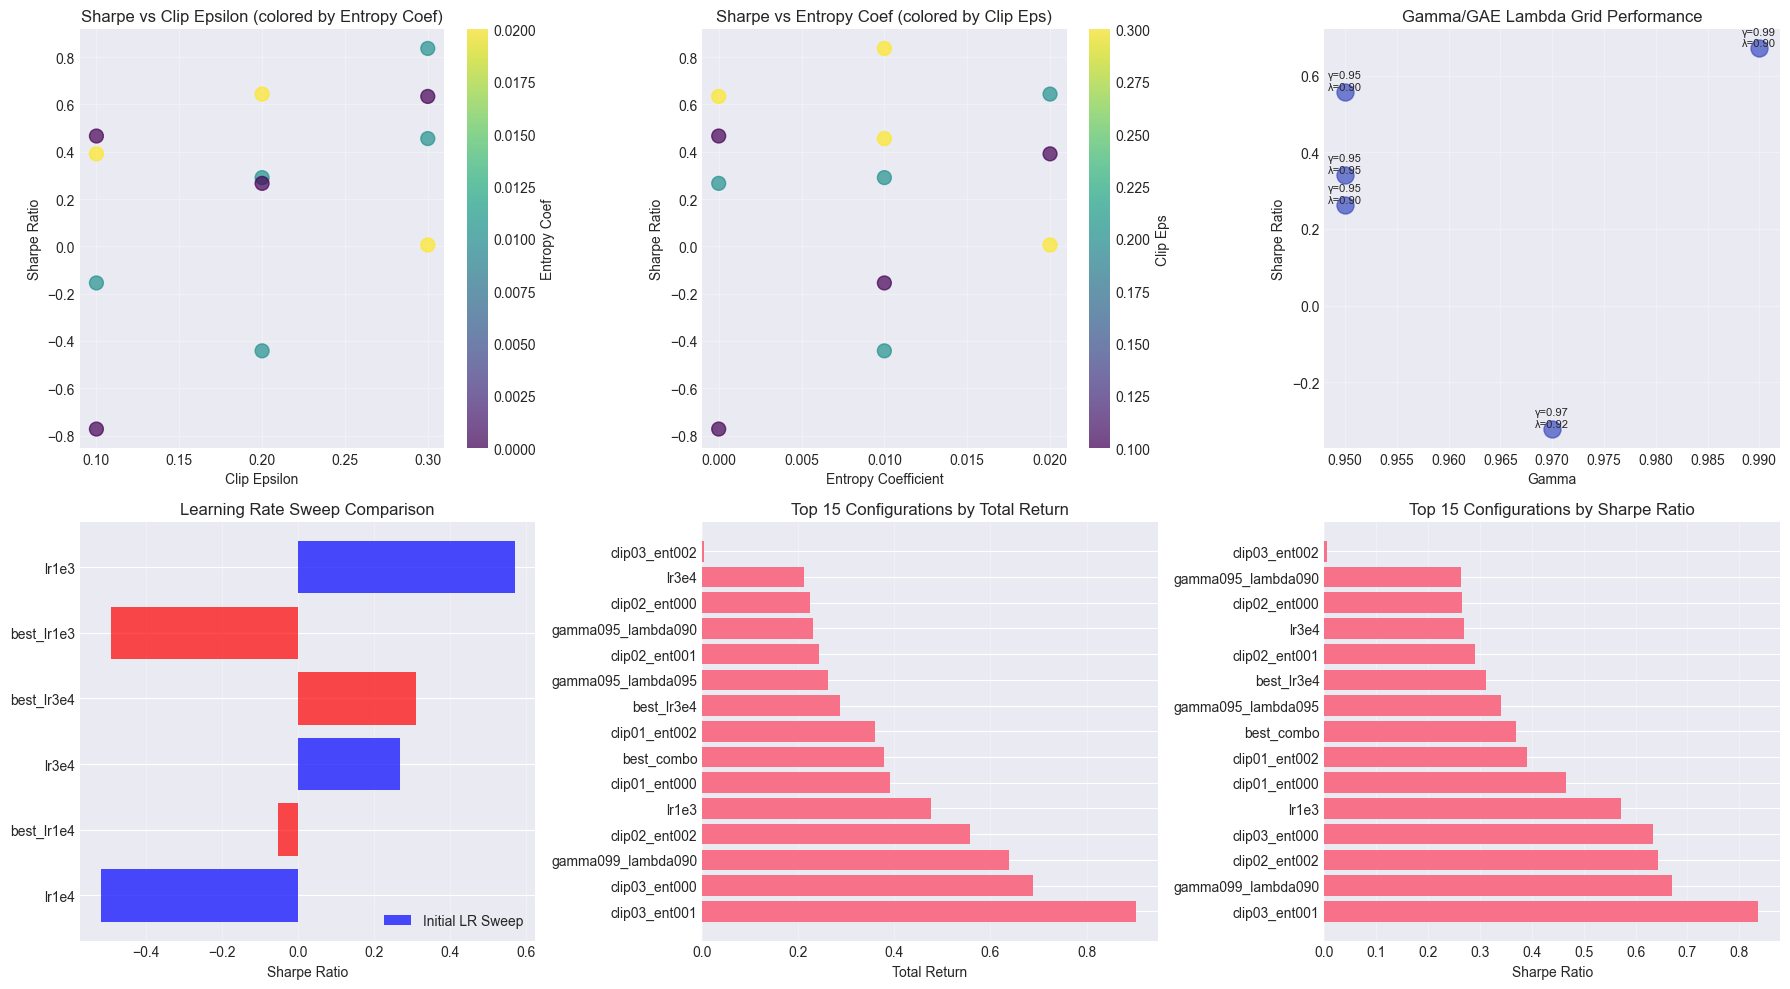

Saved hyperparameter sensitivity plot to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_sensitivity.png


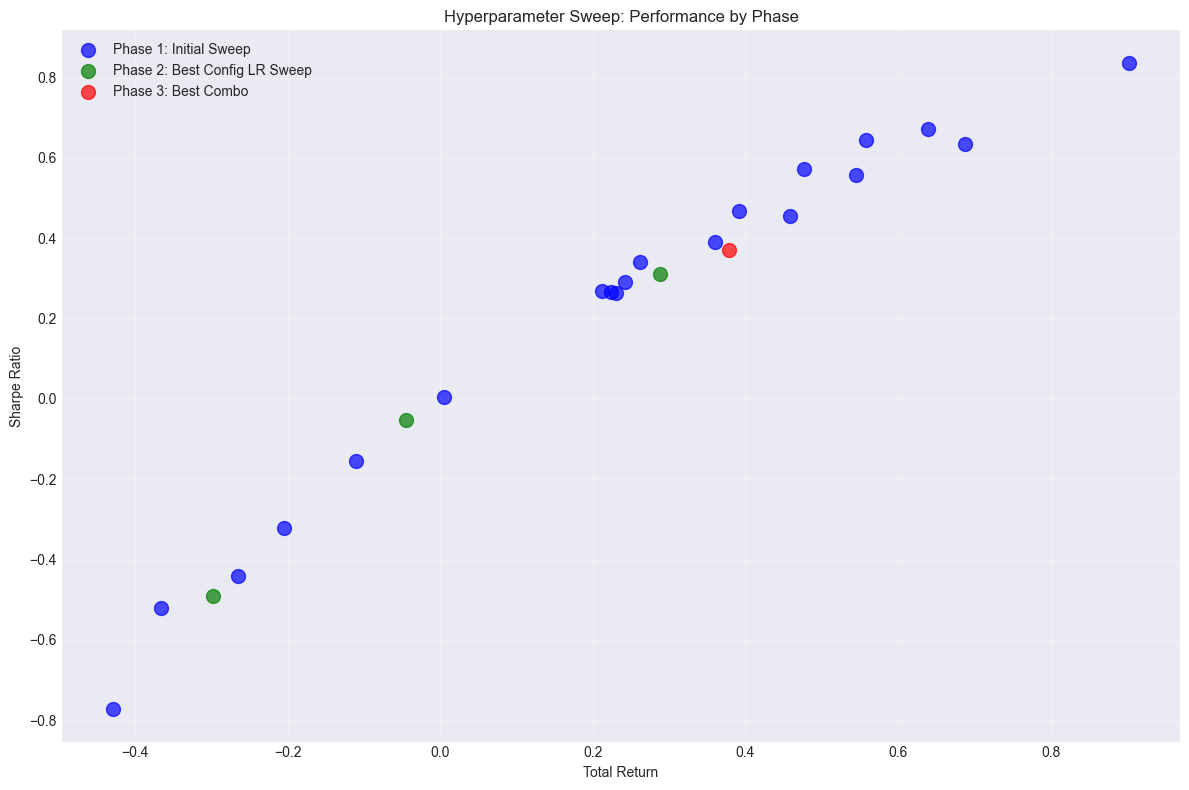

Saved phase comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_phase_comparison.png

=== Best/Worst Configurations ===

Best Configuration (by Sharpe):
name                 clip03_ent001
total_return              0.903013
annualized_return         0.175084
sharpe                    0.836786
max_drawdown               0.22093
Name: 7, dtype: object

Best Config Details:
  Phase: Phase 1: Initial Sweep
  Category: Clip/Entropy Grid
  clip_eps: 0.3
  entropy_coef: 0.01
  gamma: 0.99
  gae_lambda: 0.95
  lr: 0.0003

Worst Configuration (by Sharpe):
name                    lr1e4
total_return        -0.366165
annualized_return   -0.108038
sharpe               -0.51976
max_drawdown         0.538949
Name: 9, dtype: object

=== Phase 2: Best Config LR Sweep ===
Best LR for best config: best_lr3e4
  Sharpe: 0.3111
  Total Return: 0.2878

=== Phase 3: Best Combo ===
Best Combo Config: best_combo
  Sharpe: 0.3704
  Total Return: 0.3782
  Combined best from each dime

In [8]:
# Create hyperparameter sensitivity plots
if hyperparams_df is not None and hyperparams_detailed_df is not None:
    # Main sensitivity plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Sharpe vs Clip Epsilon (from clip/entropy grid)
    ax = axes[0, 0]
    clip_data = hyperparams_detailed_df[
        (hyperparams_detailed_df['clip_eps'].notna()) & 
        (hyperparams_detailed_df['category'] == 'Clip/Entropy Grid')
    ]
    if not clip_data.empty:
        scatter = ax.scatter(clip_data['clip_eps'], clip_data['sharpe'], 
                           c=clip_data['entropy_coef'], s=100, alpha=0.7, cmap='viridis')
        ax.set_xlabel('Clip Epsilon')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Sharpe vs Clip Epsilon (colored by Entropy Coef)')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Entropy Coef')
    
    # Plot 2: Sharpe vs Entropy Coefficient (from clip/entropy grid)
    ax = axes[0, 1]
    ent_data = hyperparams_detailed_df[
        (hyperparams_detailed_df['entropy_coef'].notna()) & 
        (hyperparams_detailed_df['category'] == 'Clip/Entropy Grid')
    ]
    if not ent_data.empty:
        scatter = ax.scatter(ent_data['entropy_coef'], ent_data['sharpe'], 
                           c=ent_data['clip_eps'], s=100, alpha=0.7, cmap='viridis')
        ax.set_xlabel('Entropy Coefficient')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Sharpe vs Entropy Coef (colored by Clip Eps)')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Clip Eps')
    
    # Plot 3: Gamma/GAE Lambda Grid
    ax = axes[0, 2]
    gamma_data = hyperparams_detailed_df[
        (hyperparams_detailed_df['category'] == 'Gamma/GAE Grid')
    ]
    if not gamma_data.empty:
        # Create labels for each point
        for _, row in gamma_data.iterrows():
            label = f"γ={row['gamma']:.2f}\nλ={row['gae_lambda']:.2f}"
            ax.scatter(row['gamma'], row['sharpe'], s=150, alpha=0.7, 
                      c=row['gae_lambda'], cmap='coolwarm')
            ax.text(row['gamma'], row['sharpe'], label, fontsize=8, 
                   ha='center', va='bottom')
        ax.set_xlabel('Gamma')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Gamma/GAE Lambda Grid Performance')
        ax.grid(True, alpha=0.3)
    
    # Plot 4: Learning Rate Comparison
    ax = axes[1, 0]
    lr_data = hyperparams_detailed_df[
        hyperparams_detailed_df['category'].isin(['Initial LR Sweep', 'Best Config LR'])
    ]
    if not lr_data.empty:
        colors = ['blue' if cat == 'Initial LR Sweep' else 'red' for cat in lr_data['category']]
        bars = ax.barh(lr_data['name'], lr_data['sharpe'], color=colors, alpha=0.7)
        ax.set_xlabel('Sharpe Ratio')
        ax.set_title('Learning Rate Sweep Comparison')
        ax.grid(True, alpha=0.3, axis='x')
        ax.legend(['Initial LR Sweep', 'Best Config LR Sweep'], loc='lower right')
    
    # Plot 5: Total Return by Configuration (Top 15)
    ax = axes[1, 1]
    hyperparams_df_sorted = hyperparams_df.sort_values('total_return', ascending=False).head(15)
    bars = ax.barh(hyperparams_df_sorted['name'], hyperparams_df_sorted['total_return'])
    ax.set_xlabel('Total Return')
    ax.set_title('Top 15 Configurations by Total Return')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Plot 6: Sharpe by Configuration (Top 15)
    ax = axes[1, 2]
    hyperparams_df_sorted_sharpe = hyperparams_df.sort_values('sharpe', ascending=False).head(15)
    bars = ax.barh(hyperparams_df_sorted_sharpe['name'], hyperparams_df_sorted_sharpe['sharpe'])
    ax.set_xlabel('Sharpe Ratio')
    ax.set_title('Top 15 Configurations by Sharpe Ratio')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "hyperparams_sensitivity.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved hyperparameter sensitivity plot to {EXPORTS_DIR / 'hyperparams_sensitivity.png'}")
    
    # Phase comparison plot
    fig, ax = plt.subplots(figsize=(12, 8))
    phase_colors = {
        'Phase 1: Initial Sweep': 'blue',
        'Phase 2: Best Config LR Sweep': 'green',
        'Phase 3: Best Combo': 'red'
    }
    for phase in hyperparams_detailed_df['phase'].unique():
        phase_data = hyperparams_detailed_df[hyperparams_detailed_df['phase'] == phase]
        ax.scatter(phase_data['total_return'], phase_data['sharpe'], 
                  label=phase, s=100, alpha=0.7, c=phase_colors.get(phase, 'gray'))
    
    ax.set_xlabel('Total Return')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('Hyperparameter Sweep: Performance by Phase')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "hyperparams_phase_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved phase comparison plot to {EXPORTS_DIR / 'hyperparams_phase_comparison.png'}")
    
    # Highlight best/worst
    print("\n=== Best/Worst Configurations ===")
    print("\nBest Configuration (by Sharpe):")
    best_sharpe = hyperparams_df.loc[hyperparams_df['sharpe'].idxmax()]
    print(best_sharpe)
    
    # Show best config details
    best_name = best_sharpe['name']
    best_details = hyperparams_detailed_df[hyperparams_detailed_df['name'] == best_name]
    if not best_details.empty:
        print(f"\nBest Config Details:")
        print(f"  Phase: {best_details.iloc[0]['phase']}")
        print(f"  Category: {best_details.iloc[0]['category']}")
        print(f"  clip_eps: {best_details.iloc[0]['clip_eps']}")
        print(f"  entropy_coef: {best_details.iloc[0]['entropy_coef']}")
        print(f"  gamma: {best_details.iloc[0]['gamma']}")
        print(f"  gae_lambda: {best_details.iloc[0]['gae_lambda']}")
        print(f"  lr: {best_details.iloc[0]['lr']}")
    
    print("\nWorst Configuration (by Sharpe):")
    worst_sharpe = hyperparams_df.loc[hyperparams_df['sharpe'].idxmin()]
    print(worst_sharpe)
    
    # Phase 2 and Phase 3 analysis
    phase2_data = hyperparams_detailed_df[hyperparams_detailed_df['phase'] == 'Phase 2: Best Config LR Sweep']
    phase3_data = hyperparams_detailed_df[hyperparams_detailed_df['phase'] == 'Phase 3: Best Combo']
    
    if not phase2_data.empty:
        print("\n=== Phase 2: Best Config LR Sweep ===")
        print(f"Best LR for best config: {phase2_data.loc[phase2_data['sharpe'].idxmax(), 'name']}")
        print(f"  Sharpe: {phase2_data['sharpe'].max():.4f}")
        print(f"  Total Return: {phase2_data.loc[phase2_data['sharpe'].idxmax(), 'total_return']:.4f}")
    
    if not phase3_data.empty:
        print("\n=== Phase 3: Best Combo ===")
        combo_config = phase3_data.iloc[0]
        print(f"Best Combo Config: {combo_config['name']}")
        print(f"  Sharpe: {combo_config['sharpe']:.4f}")
        print(f"  Total Return: {combo_config['total_return']:.4f}")
        print(f"  Combined best from each dimension:")
        print(f"    clip_eps: {combo_config['clip_eps']}")
        print(f"    entropy_coef: {combo_config['entropy_coef']}")
        print(f"    gamma: {combo_config['gamma']}")
        print(f"    gae_lambda: {combo_config['gae_lambda']}")
        print(f"    lr: {combo_config['lr']}")


In [9]:
# Export hyperparameter tables
if hyperparams_df is not None:
    export_table_csv(hyperparams_df, EXPORTS_DIR / "hyperparams_summary.csv")
    export_table_latex(hyperparams_df, EXPORTS_DIR / "hyperparams_summary.tex", float_format="%.4f")
    export_table_html(hyperparams_df, EXPORTS_DIR / "hyperparams_summary.html", classes='table table-striped')
    
if hyperparams_detailed_df is not None:
    # Export full detailed dataframe
    export_table_csv(hyperparams_detailed_df, EXPORTS_DIR / "hyperparams_detailed.csv")
    export_table_latex(hyperparams_detailed_df, EXPORTS_DIR / "hyperparams_detailed.tex", float_format="%.4f")
    
    # Export summary by phase
    if 'phase' in hyperparams_detailed_df.columns:
        phase_summary = hyperparams_detailed_df.groupby('phase').agg({
            'sharpe': ['max', 'mean', 'std'],
            'total_return': ['max', 'mean', 'std'],
            'name': 'count'
        }).round(4)
        phase_summary.columns = ['_'.join(col).strip() for col in phase_summary.columns.values]
        phase_summary = phase_summary.rename(columns={'name_count': 'num_configs'})
        export_table_csv(phase_summary, EXPORTS_DIR / "hyperparams_phase_summary.csv")
        print("\nPhase Summary:")
        print(phase_summary.to_string())


Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_summary.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_summary.tex
Exported HTML table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_summary.html
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_detailed.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_detailed.tex
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_phase_summary.csv

Phase Summary:
                               sharpe_max  sharpe_mean  sharpe_std  total_return_max  total_return_mean  total_return_std  num_configs
phase                                                                                                                                 
Phase 1: Initial Sweep             0.8368       0.2227      0.4469            0.9030             0.2409            0.3687   

In [10]:
# Load and display metrics table for baseline comparison
metrics_path = RESULTS_DIR / "ppo_hyperparams" / "best_vs_baselines_metrics.json"

if metrics_path.exists():
    import pandas as pd
    
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    
    # Convert to DataFrame for nice display
    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df[['total_return', 'annualized_return', 'sharpe', 'max_drawdown']]
    metrics_df.columns = ['Total Return', 'Annualized Return', 'Sharpe', 'Max Drawdown']
    metrics_df = metrics_df.round(4)
    
    # Identify best config row (highest Sharpe)
    best_config_row = metrics_df['Sharpe'].idxmax()
    
    print("Baseline Comparison Metrics Table:")
    print("=" * 70)
    
    # Display with highlighting for best config
    def highlight_best(row):
        if row.name == best_config_row:
            return ['background-color: #90EE90'] * len(row)  # Light green
        return [''] * len(row)
    
    styled_df = metrics_df.style.apply(highlight_best, axis=1)
    display(styled_df)
    
    print(f"\nBest Config (highlighted in green): {best_config_row}")
    print(f"  Sharpe Ratio: {metrics_df.loc[best_config_row, 'Sharpe']:.4f}")
    print(f"  Total Return: {metrics_df.loc[best_config_row, 'Total Return']:.4f}")
    print(f"  Annualized Return: {metrics_df.loc[best_config_row, 'Annualized Return']:.4f}")
    print(f"  Max Drawdown: {metrics_df.loc[best_config_row, 'Max Drawdown']:.4f}")
else:
    print(f"Metrics file not found: {metrics_path}")
    print("Run exp_ppo_hyperparams.py to generate the metrics.")


Baseline Comparison Metrics Table:


,Total Return,Annualized Return,Sharpe,Max Drawdown
PPO Baseline,-0.220000,-0.063400,-0.349300,0.375700
Buy & Hold,0.879500,0.181000,0.868800,0.245000
MA Crossover,-0.199900,-0.057100,-0.273600,0.466900
Best Config (clip03_ent001),1.054400,0.209000,1.092000,0.220900



Best Config (highlighted in green): Best Config (clip03_ent001)
  Sharpe Ratio: 1.0920
  Total Return: 1.0544
  Annualized Return: 0.2090
  Max Drawdown: 0.2209


Best Hyperparameter Config vs Baselines Comparison:

Best Hyperparameter Config: clip03_ent001
  Sharpe Ratio: 0.8368
  Total Return: 0.9030

Comparison to Baseline PPO:
  Baseline PPO Sharpe: -0.5069
  Improvement: +1.3437 (-265.1%)
  Baseline PPO Return: -0.3111
  Improvement: +1.2141 (-390.3%)

Displaying comparison plot...


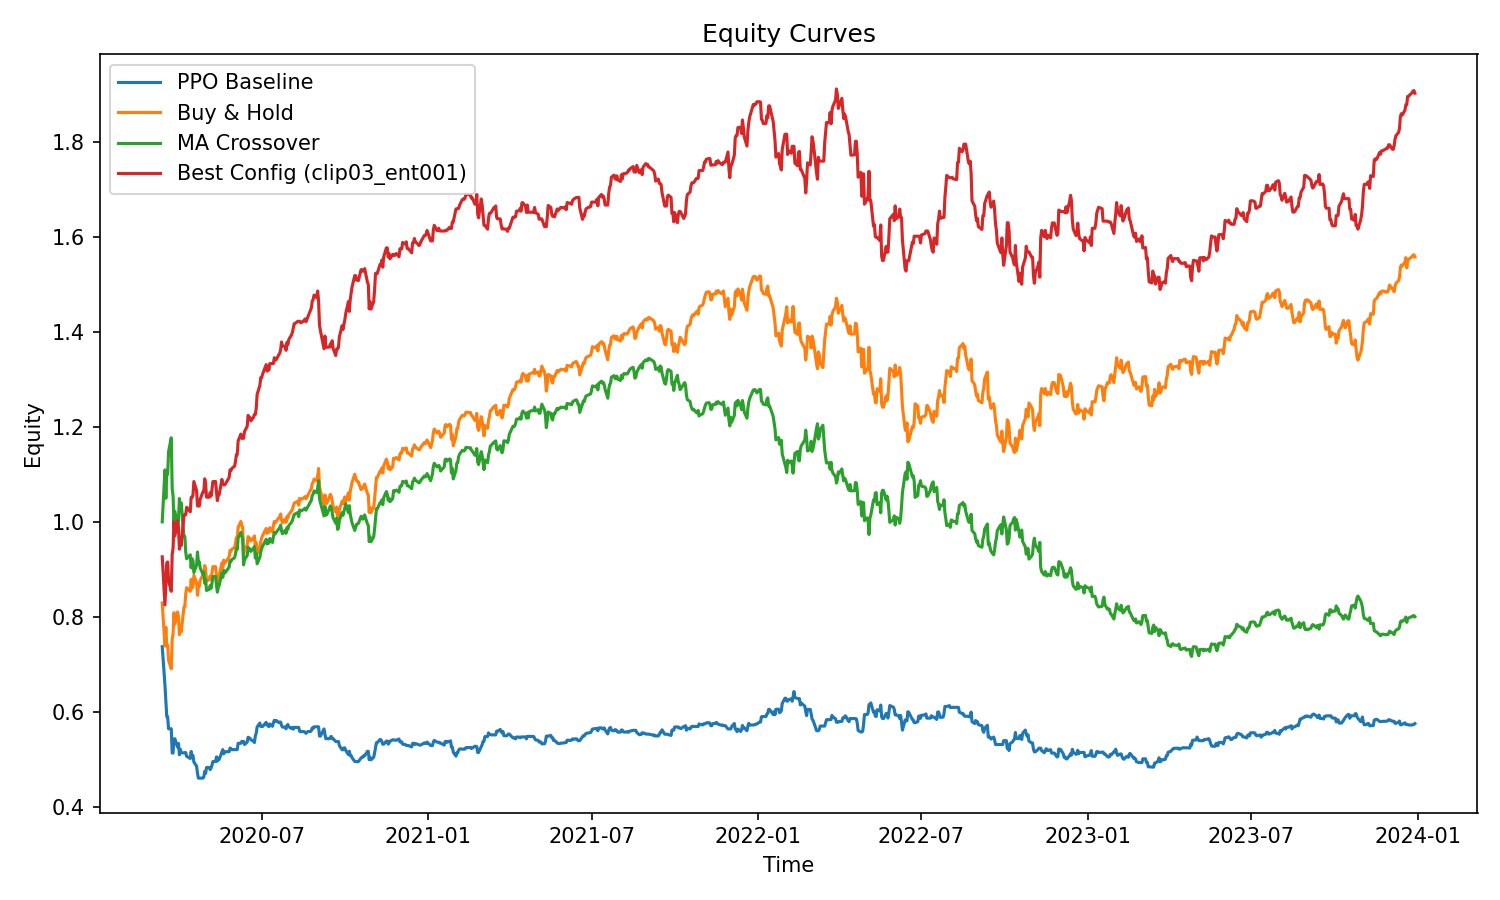


Plot saved at: /Users/nickdonato/finm-rl-project/results/ppo_hyperparams/best_vs_baselines_equity.png


In [11]:
# Display baseline comparison plot (best hyperparameter config vs baselines)
hyperparams_dir = RESULTS_DIR / "ppo_hyperparams"
comparison_plot_path = hyperparams_dir / "best_vs_baselines_equity.png"

if comparison_plot_path.exists():
    from IPython.display import Image, display
    
    print("Best Hyperparameter Config vs Baselines Comparison:")
    print("=" * 70)
    
    # Find best config name
    if hyperparams_df is not None:
        best_config_name = hyperparams_df.loc[hyperparams_df['sharpe'].idxmax(), 'name']
        best_sharpe = hyperparams_df.loc[hyperparams_df['sharpe'].idxmax(), 'sharpe']
        best_return = hyperparams_df.loc[hyperparams_df['sharpe'].idxmax(), 'total_return']
        
        print(f"\nBest Hyperparameter Config: {best_config_name}")
        print(f"  Sharpe Ratio: {best_sharpe:.4f}")
        print(f"  Total Return: {best_return:.4f}")
        
        # Compare to baseline PPO
        core_baselines_path = RESULTS_DIR / "core_baselines" / "core_metrics.json"
        if core_baselines_path.exists():
            with open(core_baselines_path, 'r') as f:
                core_metrics = json.load(f)
            
            baseline_ppo_sharpe = core_metrics.get('PPO', {}).get('sharpe', None)
            baseline_ppo_return = core_metrics.get('PPO', {}).get('total_return', None)
            
            if baseline_ppo_sharpe is not None:
                sharpe_improvement = best_sharpe - baseline_ppo_sharpe
                return_improvement = best_return - baseline_ppo_return
                
                print(f"\nComparison to Baseline PPO:")
                print(f"  Baseline PPO Sharpe: {baseline_ppo_sharpe:.4f}")
                print(f"  Improvement: {sharpe_improvement:+.4f} ({sharpe_improvement/baseline_ppo_sharpe*100:+.1f}%)")
                print(f"  Baseline PPO Return: {baseline_ppo_return:.4f}")
                print(f"  Improvement: {return_improvement:+.4f} ({return_improvement/baseline_ppo_return*100:+.1f}%)")
    
    print(f"\nDisplaying comparison plot...")
    display(Image(str(comparison_plot_path)))
    print(f"\nPlot saved at: {comparison_plot_path}")
else:
    print("Baseline comparison plot not found.")
    print(f"Expected path: {comparison_plot_path}")
    print("Run exp_ppo_hyperparams.py to generate the comparison plot.")


## 3. State/Environment Ablation Analysis

Compare performance across different state representations and environment configurations.


In [ ]:
# Load state/env ablation results
states_envs_dir = RESULTS_DIR / "states_envs"
states_envs_data = []

for json_file in states_envs_dir.glob("*_metrics.json"):
    with open(json_file, 'r') as f:
        metrics = json.load(f)
        name = json_file.stem.replace("_metrics", "")
        row = {"config": name}
        # Remove shaping_config if present
        if 'shaping_config' in metrics:
            del metrics['shaping_config']
        row.update(metrics)
        states_envs_data.append(row)

if states_envs_data:
    states_envs_df = pd.DataFrame(states_envs_data)
    print("State/Environment Ablation Results:")
    print(states_envs_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(states_envs_df['config'], states_envs_df[metric])
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "states_envs_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved state/env comparison plot to {EXPORTS_DIR / 'states_envs_comparison.png'}")
    
    # Export table
    export_table_csv(states_envs_df, EXPORTS_DIR / "states_envs_comparison.csv")
    export_table_latex(states_envs_df, EXPORTS_DIR / "states_envs_comparison.tex", float_format="%.4f")
else:
    print("State/Environment results not found")
    states_envs_df = None


In [ ]:
# Plot all 3 equity curves together
if states_envs_data:
    from eval.plotting import plot_equity_curves
    import pandas as pd
    
    # Load equity curves from JSON files
    equity_curves = {}
    dates_list = None
    
    for config_name in ['single_simple', 'single_rich', 'pairs_simple']:
        equity_json_path = states_envs_dir / f"{config_name}_equity.json"
        if equity_json_path.exists():
            with open(equity_json_path, 'r') as f:
                equity_data = json.load(f)
                equity_curves[config_name] = np.array(equity_data['equity'])
                # Use dates from first available config
                if dates_list is None and 'dates' in equity_data:
                    dates_list = pd.to_datetime(equity_data['dates'])
    
    if equity_curves:
        # Align all curves to minimum length
        min_len = min(len(eq) for eq in equity_curves.values())
        aligned_curves = {name: eq[:min_len] for name, eq in equity_curves.items()}
        if dates_list is not None:
            aligned_dates = dates_list[:min_len]
        else:
            aligned_dates = None
        
        # Create combined plot
        fig, ax = plt.subplots(figsize=(14, 8))
        for name, eq in aligned_curves.items():
            label = name.replace('_', ' ').title()
            ax.plot(aligned_dates if aligned_dates is not None else range(len(eq)), eq, label=label, linewidth=2)
        
        ax.set_xlabel('Date' if aligned_dates is not None else 'Time', fontsize=12)
        ax.set_ylabel('Equity', fontsize=12)
        ax.set_title('State/Environment Ablation: Equity Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        output_path = EXPORTS_DIR / "states_envs_equity_curves.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved combined equity curves plot to {output_path}")
    else:
        print("Equity curve JSON files not found. Re-run exp_states_envs.py to generate them.")


## 4. Regime Analysis

Analyze PPO performance across different market regimes: Bull/Bear and Volatility regimes.


In [ ]:
# Load regime comparison data
regime_dir = RESULTS_DIR / "regimes"
regime_comparison_path = regime_dir / "regime_comparison.csv"
regime_metrics_path = regime_dir / "regime_metrics.json"

if regime_comparison_path.exists():
    regime_df = pd.read_csv(regime_comparison_path)
    print("Regime Comparison Data:")
    print(regime_df.to_string(index=False))
else:
    print("Regime comparison CSV not found")
    regime_df = None

# Also load JSON for additional details
if regime_metrics_path.exists():
    with open(regime_metrics_path, 'r') as f:
        regime_metrics_json = json.load(f)
    print("\nRegime Metrics (JSON):")
    print(json.dumps(regime_metrics_json, indent=2))
else:
    print("Regime metrics JSON not found")
    regime_metrics_json = None


In [ ]:
# Visualize regime performance with bar charts
if regime_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        # Separate by regime type
        bull_bear_data = regime_df[regime_df['regime_type'] == 'bull_bear']
        vol_data = regime_df[regime_df['regime_type'] == 'volatility']
        
        x = np.arange(max(len(bull_bear_data), len(vol_data)))
        width = 0.35
        
        if not bull_bear_data.empty:
            ax.bar(x[:len(bull_bear_data)] - width/2, bull_bear_data[metric], 
                   width, label='Bull/Bear', alpha=0.8)
        if not vol_data.empty:
            ax.bar(x[:len(vol_data)] + width/2, vol_data[metric], 
                   width, label='Volatility', alpha=0.8)
        
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.set_title(f'{metric.replace("_", " ").title()} by Regime')
        ax.set_xticks(x[:max(len(bull_bear_data), len(vol_data))])
        if not bull_bear_data.empty:
            labels = list(bull_bear_data['regime_label']) + [''] * (len(x) - len(bull_bear_data))
            ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "regime_performance.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved regime performance plot to {EXPORTS_DIR / 'regime_performance.png'}")


In [ ]:
# Create heatmap of regime performance
if regime_df is not None:
    pivot_df = regime_df.pivot_table(
        index='regime_label', 
        columns='regime_type', 
        values=['total_return', 'annualized_return', 'sharpe', 'max_drawdown'],
        aggfunc='first'
    )
    
    # Flatten column names
    pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_df.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax)
    ax.set_title('Regime Performance Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "regime_heatmap.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved regime heatmap to {EXPORTS_DIR / 'regime_heatmap.png'}")
    
    print("\nRegime Performance Table:")
    print(pivot_df.to_string())


In [ ]:
# Export regime analysis tables and summary statistics
if regime_df is not None:
    # Export main comparison table
    export_table_csv(regime_df, EXPORTS_DIR / "regime_comparison_analysis.csv")
    export_table_latex(regime_df, EXPORTS_DIR / "regime_comparison_analysis.tex", float_format="%.4f")
    export_table_html(regime_df, EXPORTS_DIR / "regime_comparison_analysis.html", classes='table table-striped')
    
    # Export separate tables for each regime type
    bull_bear_df = regime_df[regime_df['regime_type'] == 'bull_bear']
    vol_df = regime_df[regime_df['regime_type'] == 'volatility']
    
    if not bull_bear_df.empty:
        export_table_csv(bull_bear_df, EXPORTS_DIR / "regime_bull_bear.csv")
        export_table_latex(bull_bear_df, EXPORTS_DIR / "regime_bull_bear.tex", float_format="%.4f")
    
    if not vol_df.empty:
        export_table_csv(vol_df, EXPORTS_DIR / "regime_volatility.csv")
        export_table_latex(vol_df, EXPORTS_DIR / "regime_volatility.tex", float_format="%.4f")
    
    # Summary statistics
    print("\n=== Regime Performance Summary ===\n")
    
    # Bull/Bear summary
    if not bull_bear_df.empty:
        print("Bull/Bear Regimes:")
        print(f"  Best Sharpe: {bull_bear_df.loc[bull_bear_df['sharpe'].idxmax(), 'regime_label']} ({bull_bear_df['sharpe'].max():.4f})")
        print(f"  Best Return: {bull_bear_df.loc[bull_bear_df['total_return'].idxmax(), 'regime_label']} ({bull_bear_df['total_return'].max():.4f})")
        print(f"  Lowest Drawdown: {bull_bear_df.loc[bull_bear_df['max_drawdown'].idxmin(), 'regime_label']} ({bull_bear_df['max_drawdown'].min():.4f})")
        print()
    
    # Volatility summary
    if not vol_df.empty:
        print("Volatility Regimes:")
        print(f"  Best Sharpe: {vol_df.loc[vol_df['sharpe'].idxmax(), 'regime_label']} ({vol_df['sharpe'].max():.4f})")
        print(f"  Best Return: {vol_df.loc[vol_df['total_return'].idxmax(), 'regime_label']} ({vol_df['total_return'].max():.4f})")
        print(f"  Lowest Drawdown: {vol_df.loc[vol_df['max_drawdown'].idxmin(), 'regime_label']} ({vol_df['max_drawdown'].min():.4f})")
        print()
    
    # Overall best
    best_overall = regime_df.loc[regime_df['sharpe'].idxmax()]
    print(f"Overall Best Regime: {best_overall['regime_type']} - {best_overall['regime_label']}")
    print(f"  Sharpe: {best_overall['sharpe']:.4f}")
    print(f"  Total Return: {best_overall['total_return']:.4f}")
    print(f"  Max Drawdown: {best_overall['max_drawdown']:.4f}")


## 5. Reward Shaping Analysis

Compare performance across different reward shaping configurations: transaction costs, risk penalties, and drawdown guards.


In [ ]:
# Load reward shaping results
reward_shaping_dir = RESULTS_DIR / "reward_shaping"
reward_shaping_data = []

for json_file in reward_shaping_dir.glob("*_metrics.json"):
    with open(json_file, 'r') as f:
        metrics = json.load(f)
        name = json_file.stem.replace("_metrics", "")
        row = {"config": name}
        
        # Extract shaping config details
        if 'shaping_config' in metrics:
            shaping_cfg = metrics['shaping_config']
            row['transaction_cost'] = shaping_cfg.get('transaction_cost', 0.0)
            row['lambda_risk'] = shaping_cfg.get('lambda_risk', 0.0)
            row['lambda_drawdown'] = shaping_cfg.get('lambda_drawdown', 0.0)
        
        # Add metrics (excluding shaping_config)
        row['total_return'] = metrics.get('total_return', float('nan'))
        row['annualized_return'] = metrics.get('annualized_return', float('nan'))
        row['sharpe'] = metrics.get('sharpe', float('nan'))
        row['max_drawdown'] = metrics.get('max_drawdown', float('nan'))
        
        reward_shaping_data.append(row)

if reward_shaping_data:
    reward_shaping_df = pd.DataFrame(reward_shaping_data)
    print("Reward Shaping Results:")
    print(reward_shaping_df.to_string(index=False))
else:
    print("Reward shaping results not found")
    reward_shaping_df = None


In [ ]:
# Visualize reward shaping comparison
if reward_shaping_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(reward_shaping_df['config'], reward_shaping_df[metric])
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "reward_shaping_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved reward shaping comparison plot to {EXPORTS_DIR / 'reward_shaping_comparison.png'}")


In [ ]:
# Plot all reward shaping equity curves together
if reward_shaping_df is not None:
    from eval.plotting import plot_equity_curves
    import pandas as pd
    
    # Load equity curves from individual PNG files would require image processing
    # Instead, we'll note that individual equity plots are available in results/reward_shaping/
    # For a combined plot, you would need to modify exp_reward_shaping.py to save equity arrays
    # For now, we'll create a comparison based on metrics
    
    # Create a comparison showing the impact of each shaping type
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort by sharpe for better visualization
    reward_shaping_sorted = reward_shaping_df.sort_values('sharpe', ascending=False)
    
    x_pos = np.arange(len(reward_shaping_sorted))
    bars = ax.barh(x_pos, reward_shaping_sorted['sharpe'])
    ax.set_yticks(x_pos)
    ax.set_yticklabels(reward_shaping_sorted['config'])
    ax.set_xlabel('Sharpe Ratio')
    ax.set_title('Reward Shaping: Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(reward_shaping_sorted.iterrows()):
        ax.text(row['sharpe'], i, f"  {row['sharpe']:.3f}", 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "reward_shaping_sharpe_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved reward shaping Sharpe comparison to {EXPORTS_DIR / 'reward_shaping_sharpe_comparison.png'}")
    
    print("\nBest Reward Shaping Configuration (by Sharpe):")
    best_shaping = reward_shaping_df.loc[reward_shaping_df['sharpe'].idxmax()]
    print(best_shaping)


In [ ]:
# Export reward shaping tables
if reward_shaping_df is not None:
    export_table_csv(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.csv")
    export_table_latex(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.tex", float_format="%.4f")
    export_table_html(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.html", classes='table table-striped')
    
    # Summary of shaping impact
    print("\n=== Reward Shaping Impact Summary ===\n")
    no_shaping = reward_shaping_df[reward_shaping_df['config'] == 'no_shaping']
    if not no_shaping.empty:
        baseline_sharpe = no_shaping.iloc[0]['sharpe']
        baseline_return = no_shaping.iloc[0]['total_return']
        print(f"Baseline (no shaping): Sharpe={baseline_sharpe:.4f}, Return={baseline_return:.4f}\n")
        
        for _, row in reward_shaping_df.iterrows():
            if row['config'] != 'no_shaping':
                sharpe_diff = row['sharpe'] - baseline_sharpe
                return_diff = row['total_return'] - baseline_return
                print(f"{row['config']}:")
                print(f"  Sharpe change: {sharpe_diff:+.4f} ({sharpe_diff/baseline_sharpe*100:+.1f}%)")
                print(f"  Return change: {return_diff:+.4f} ({return_diff/baseline_return*100:+.1f}%)")
                print(f"  Config: cost={row['transaction_cost']}, risk={row['lambda_risk']}, drawdown={row['lambda_drawdown']}")
                print()


## 6. Robustness Analysis


## 6. Robustness Analysis


In [ ]:
# Load robustness results
robustness_dir = RESULTS_DIR / "ppo_seed_pretrain_compare"
robustness_summary_path = robustness_dir / "summary_test_metrics.csv"
robustness_group_stats_path = robustness_dir / "summary_group_stats.csv"

if robustness_summary_path.exists():
    from eval.summarize import summarize_runs
    
    # Load individual run JSONs
    run_payloads = []
    for json_file in robustness_dir.glob("*.json"):
        if json_file.name not in ["summary_test_metrics.json"]:
            with open(json_file, 'r') as f:
                run_payloads.append(json.load(f))
    
    if run_payloads:
        robustness_df = summarize_runs(run_payloads, metric_key="test_metrics")
        print("Robustness Summary (per run):")
        print(robustness_df.to_string(index=False))
        
        # Load group statistics
        if robustness_group_stats_path.exists():
            group_stats_df = pd.read_csv(robustness_group_stats_path)
            print("\nGroup Statistics (mean/std by pretrained vs non-pretrained):")
            print(group_stats_df.to_string(index=False))
            
            # Visualize group statistics
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            metrics = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
            
            for idx, metric in enumerate(metrics):
                ax = axes[idx // 2, idx % 2]
                metric_data = group_stats_df[group_stats_df['metric'] == metric]
                
                groups = metric_data['group'].unique()
                means = [metric_data[metric_data['group'] == g]['mean'].values[0] for g in groups]
                stds = [metric_data[metric_data['group'] == g]['std'].values[0] for g in groups]
                
                x_pos = np.arange(len(groups))
                bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
                ax.set_xticks(x_pos)
                ax.set_xticklabels(groups)
                ax.set_ylabel(metric.replace("_", " ").title())
                ax.set_title(f'{metric.replace("_", " ").title()} by Group (mean ± std)')
                ax.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.savefig(EXPORTS_DIR / "robustness_comparison.png", dpi=150, bbox_inches='tight')
            plt.show()
            print(f"Saved robustness comparison plot to {EXPORTS_DIR / 'robustness_comparison.png'}")
            
            # Export tables
            export_table_csv(group_stats_df, EXPORTS_DIR / "robustness_group_stats.csv")
            export_table_latex(group_stats_df, EXPORTS_DIR / "robustness_group_stats.tex", float_format="%.4f")
    else:
        print("No robustness run data found")
        robustness_df = None
        group_stats_df = None
else:
    print("Robustness results not found")
    robustness_df = None
    group_stats_df = None
